[*********************100%%**********************]  1 of 1 completed


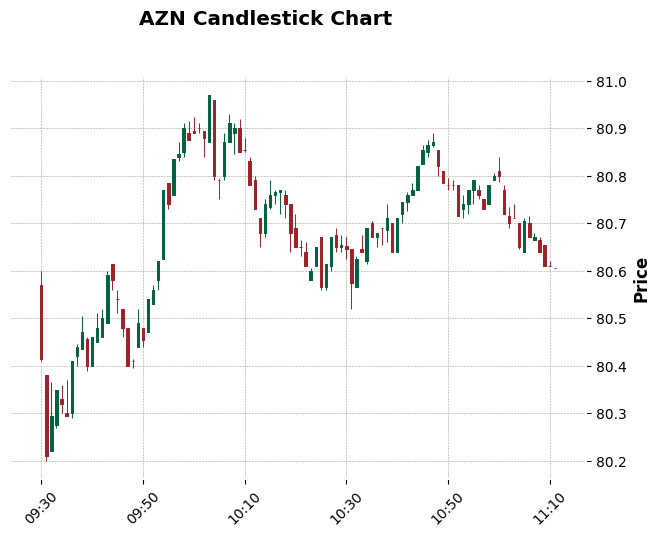

In [6]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import mplfinance as mpf

# Download recent data
recent_data = yf.download("AZN", period="1d", interval="1m")

# Drop unnecessary columns
recent_data = recent_data.drop(columns=["Adj Close", "Volume"])

# Create a candlestick chart
mpf.plot(
    recent_data,
    type="candle",
    style="charles",
    title="AZN Candlestick Chart",
    ylabel="Price",
)

# Show the plot
mpf.show()